## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus
from sklearn.model_selection import train_test_split


import os
import time
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080, compute capability 8.9


In [3]:
def chunk_and_batch(corpus, chunk_size, train_batch_size, test_batch_size, repeat=True, ratio=0.8):
    ds = tf.data.Dataset.from_tensor_slices(corpus)
    ds = ds.batch(chunk_size, drop_remainder=True)

    ds_shuffled = ds.shuffle(buffer_size=10000, seed=42)

    num_segments = ds_shuffled.cardinality().numpy()      # e.g. 1000 segments
    num_train    = int(ratio * num_segments)               # 80% of them

    # 3. Split into train vs. test
    ds_train = ds_shuffled.take(num_train)
    ds_test  = ds_shuffled.skip(num_train)

    # 4. (Optionally) Batch these 512-segments into training batches
    #   —for example, 32 segments per batch:
    ds_train = ds_train.batch(train_batch_size).prefetch(tf.data.AUTOTUNE)
    ds_test  = ds_test.batch(test_batch_size).prefetch(tf.data.AUTOTUNE)

    if repeat:
        ds_train = ds_train.repeat()
        ds_test  = ds_test.repeat()

    return ds_train, ds_test

In [4]:
max_seq_len = 512

tokenizer = pkl.load(open('tokenizers/CNN_QA8k_balanced.pkl', 'rb'))
tokenizer.create_hash()
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>"])

In [5]:
corpus = pkl.load(open('corpus/corpus_CNN_QA8k_balanced', 'rb'))[0]

print(corpus.shape)

ds_train, ds_test = chunk_and_batch(corpus, chunk_size=max_seq_len, train_batch_size=32, test_batch_size=8, repeat=True)


(7997940,)


## Define Model

In [6]:
initial_lr = 1e-4
decay_steps = 20000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 512
embed_dim = 512
tf_blocks = 8
heads = 8
ff_dim = 4*embed_dim
weight_decay = 0.01
dropout = 0.1

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    tokenizer=tokenizer,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    )

losses_train = []
losses_test = []


In [7]:
name = "model_8k_CNN_plus_QA"


ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [8]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [9]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 29743765


In [10]:
def train_loop(ds_train, ds_test):
    for i, (batch_train, batch_test) in tqdm(enumerate(zip(ds_train, ds_test))):
        loss_train = model.train_step(batch_train).numpy()
        losses_train.append(loss_train)
        
        loss_test = model.evaluate(batch_test).numpy()
        losses_test.append(loss_test)

        if (i+1) % 1000 == 0:
            ckpt_manager.save()
            pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

        lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
        print(loss_train, loss_test, lr)
    return losses_train, losses_test

In [11]:
train_loop(ds_train, ds_test)

0it [00:00, ?it/s]

🔄 Tracing train_step; token shape: (None, None)
🔄 Tracing train_step; token shape: (None, None)
1.728676 1.267033 1.2499568e-05
1.8126715 1.397321 1.2499133e-05
1.7184318 1.4311336 1.2498699e-05
1.7649497 1.4700595 1.2498268e-05
1.7766677 1.441482 1.2497832e-05
1.7865933 1.4488099 1.2497401e-05
1.8155608 1.5784022 1.2496968e-05
1.7524136 1.4540833 1.2496534e-05
1.7806921 1.3550723 1.2496102e-05
1.7618248 1.4470835 1.24956705e-05
1.7239046 1.2170235 1.2495234e-05
1.7490358 1.4009159 1.2494802e-05
1.8214505 1.3170927 1.2494372e-05
1.7463692 1.4888407 1.2493936e-05
1.7780464 1.349458 1.2493503e-05
1.8009093 1.5042065 1.2493073e-05
1.8344663 1.4712306 1.2492637e-05
1.7794122 1.4643366 1.2492205e-05
1.7674636 1.4742018 1.249177e-05
1.7883013 1.5729791 1.24913395e-05
1.778777 1.458597 1.2490907e-05
1.8302907 1.5478575 1.2490472e-05
1.7701466 1.4381287 1.2490042e-05
1.7345982 1.4400917 1.2489608e-05
1.7508788 1.5316019 1.2489173e-05
1.7127117 1.4922906 1.2488741e-05
1.7168628 1.4106869 1.2488

KeyboardInterrupt: 

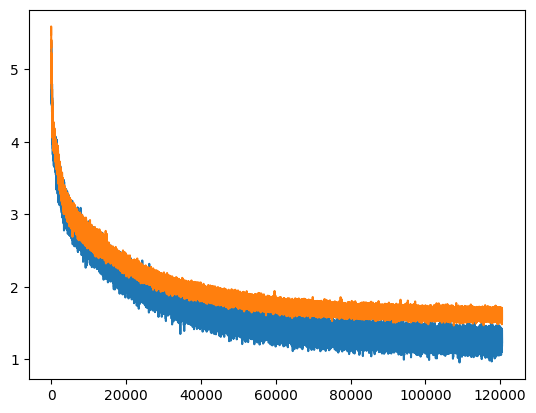

In [12]:
plt.plot(losses_test[100:], label="Test Loss")
plt.plot(losses_train[100:], label="Train Loss")

In [31]:
text = "Who is the leader of Russia?"
text = text.lower()
SOS = tf.convert_to_tensor([[tokenizer.token_to_idx["<s>"]]])
Q = tf.convert_to_tensor([[tokenizer.token_to_idx["<q>"]]])
A = tf.convert_to_tensor([[tokenizer.token_to_idx["<a>"]]])
indices = tf.cast(tokenizer.encode(text), tf.int32)
indices = tf.concat([SOS, Q, indices, A], axis=1)
print(indices)

#text = "(cnn)"
#text = text.lower()
#SOS = tf.convert_to_tensor([[tokenizer.token_to_idx["<s>"]]])
#Q = tf.convert_to_tensor([[tokenizer.token_to_idx["<q>"]]])
#A = tf.convert_to_tensor([[tokenizer.token_to_idx["<a>"]]])
#indices = tf.cast(tokenizer.encode(text), tf.int32)
#indices = tf.concat([SOS, indices], axis=1)
#print(indices)

import textwrap
import ipywidgets as widgets
from IPython.display import display

T = 1
#tf.random.set_seed(42)
wrapper = textwrap.TextWrapper(width=80)

# create a read-only text area
ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)

for i in range(768):
    logits = model.call(indices)[0, -1:]
    idx = tf.cast(
        tf.random.categorical(logits / T, num_samples=1),
        tf.int32
    )
    indices = tf.concat([indices, idx], axis=1)

    text_pred = (
        tokenizer
        .decode(indices)
        .numpy()[0]
        .decode('utf-8')
        .replace("\n", " ")
    )
    ta.value = wrapper.fill(text_pred)  # this updates in-place

    if idx[0, 0] == tokenizer.token_to_idx["</s>"]:
        break

  0%|          | 0/8000 [00:00<?, ?it/s]

tf.Tensor(
[[8337 8339  439    1  353    1  339    1 1722    1  352    1 2603   32
  8340]], shape=(1, 15), dtype=int32)


Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

In [35]:
from sklearn.cluster import KMeans

def cosine_similarity(embed_a, embed_b):
    """
    Compute the cosine similarity between two vectors.
    """
    embed_b_T = tf.transpose(embed_b)
    dot_product = embed_a@embed_b_T
    
    norm_a = tf.linalg.norm(embed_a, axis=1, keepdims=True)
    norm_b = tf.linalg.norm(embed_b_T, axis=0, keepdims=True)

    return dot_product / (norm_a * norm_b)


def cluster(X, n_clusters, normalize=True):
    if normalize:
        X = X/np.linalg.norm(X, axis=1, keepdims=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_

    return inertia, labels, clusters


class EmbeddingClustering:
    def __init__(self, tokenizer, n_clusters=10):
        
        self.tokenizer = tokenizer
        self.n_clusters = n_clusters

    def fit(self, word_embed, normalize=True):
        inertia, labels, clusters = cluster(word_embed, self.n_clusters, normalize)
        self.word_embed = word_embed
        self.inertia = inertia
        self.labels = labels
        self.clusters = tf.convert_to_tensor(clusters, dtype=tf.float32)

        cos_sim = cosine_similarity(self.clusters, word_embed, normalize)
        self.idx_list =  tf.argsort(cos_sim, axis=-1, direction='DESCENDING', stable=False, name=None)

    def print_clusters(self, n_words=10):
        for idx in self.idx_list:
            for i in idx[:n_words]:
                word = self.tokenizer.decode(tf.expand_dims(tf.cast(i, tf.int32), axis=0))
                word = word.numpy().decode('utf-8')
                print(word)
            print("\n")


def cosine_similarity(embed_a, embed_b, normalize=True):
    """
    Compute the cosine similarity between two vectors.
    """
    if normalize:
        embed_a = tf.nn.l2_normalize(embed_a, axis=1)
        embed_b = tf.nn.l2_normalize(embed_b, axis=1)
    dot_product = embed_a@tf.transpose(embed_b)


    return dot_product

In [37]:
word_embed = model.word_embed
embedding_clustering = EmbeddingClustering(tokenizer, n_clusters=10)
embedding_clustering.fit(word_embed, normalize=True)
embedding_clustering.print_clusters(n_words=10)

grees
№
瑚
isra
aziland
ricts
wedn
figh
earli
ǥ


[
sop
mus
diar
suf
stu
streng
rhe
joh
syl


took
gave
caused
expressed
issued
told
received
encouraged
tells
urged


return
break
commit
guaran
announce
refer
enlighten
monu
thanks
draw


25
190
15
19
195
22
30
12
28
27


people's
stral
renewable
economic
mother's
women's
cultural
entire
social
president's


usalem
employe
figh
grees
aziland
anyahu
ricts
earli
weren
attem


refle
destru
effe
distin
scr
colle
sele
dete
incl
prote


doesn't
haven't
i'd
didn't
never
hasn't
wouldn't
don't
i've
we've


ם
juries
統
opinions
grees
ĭ
warz
tuber
uries
obamac




# Overlap

In [ ]:
word_embed = model.word_embed

text = "russia"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed1 = tf.expand_dims(word_embed[idx[0][0]], axis=0)


text = "putin"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed2 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

text = "netanyahu"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed3 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

embed = embed1 - embed2 + embed3

cosine_sim = cosine_similarity(embed, word_embed, normalize=False)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[1602]], shape=(1, 1), dtype=int32)
tf.Tensor([[3512]], shape=(1, 1), dtype=int32)
tf.Tensor([[5393]], shape=(1, 1), dtype=int32)
netanyahu
russia
israel
hamas
israelis
jerusalem
tehran
kiev
gaza
palestinians
democr
beirut
azer
syria
egypt
idf
iran
britain
palestinian
abbas
tunisia
alger
lebanon
perpe
israeli
davos
brahim
controver
hezbollah
hagel
jevich
norway
fah
guinea
khamenei
cuba
anbar
utt
khamene
hezbol
weren
canada
sunnis
dipl
stoke
lavrov
aviv
karzai
israel's
arct
cambodia
zuckerberg
yanukov
yad
ukraine
pakistan
carney
netherlands
cairo
lieberman
panetta
homs
zawah
austria
espion
wawrink
vinc
libertar
libya
poland
indonesia
liby
merkel
pyongyang
tik
airstrikes
ibrahimovic
abe
iran's
yugo
kass
mosul
galax
yemen
scotland
settlements
sudan
nuri
niger
palestine
tsvangira
ieval
iaea
denmark
hmer
tahrir
nusra
sarkoz
ukrain
bolivia


In [75]:
word_embed = model.word_embed

text = "putin"
text = text.lower()

idx = tf.cast(tokenizer.encode(text), tf.int32)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.decode(i).numpy().decode('utf-8'))

  0%|          | 0/8000 [00:00<?, ?it/s]

tf.Tensor([[6208]], shape=(1, 1), dtype=int32)
putin
russia's
netanyahu
moscow
pistorius
ukraine
nadal
gadhafi
mcconnell
gadha
ukrain
kenned
zimbabwe
hussein
ž
ṃ
palestinians
eurozone
י
boehner
federer
beid
ukrainian
uset
mous
vah
weap
mohamed
russia
nandez
sein
下
versary
ė
christie
mubarak
ṇ
coln
thew
grees
mediter
ansas
س
obamac
leban
industri
charle
osop
warz
nobody
ahmad
ț
viet
moham
armen
€
yugo
amo
mah
ṛ
ʼ
itre
atest
traged
kie
mandu
ễ
usetts
polit
barack
muham
ʾ
citiz
figh
surger
isode
ְ
aziland
territor
puer
fuk
е
blig
syri
obama
mohammed
clinton
damascus
ingu
ğ
olas
pread
yout
assad
colom
ailand
caine
usalem
palestin
demonstrators


In [ ]:
word_embed = model.word_embed

text = "netanyahu"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[5393]], shape=(1, 1), dtype=int32)
netanyahu
abulary
hagel
maduro
espion
yingluck
onsored
nandez
saleh
natur
ailand
hezbol
panetta
biden
shinse
kerry
gibbs
sarkozy
fundam
hift
patro
signific
anonymity
putin
mugabe
lades
boehner
pelosi
medvedev
ahmadinejad
warri
thaksin
landrieu
shaba
gbag
accust
charac
fahren
liby
peninsu
helicop
zuma
traged
portugu
morsy
publ
enjo
ilight
abbas
erdogan
ieval
bachmann
yanukovych
leep
confir
rodrigue
secutive
provin
mccain's
moil
subsequ
abled
juvent
o'ne
guardiola
lieberman
karzai
catastro
ouatt
zardari
possib
toug
theless
burma
carney
ricul
zhok
barcelon
dort
sunnis
lomb
snowden
avez
diffic
sess
khamenei
exer
golese
copen
rouhani
ipal
transparen
ultane
mccain
boeh
diox
citiz
adjac
nieto
lavrov


## Mean Pooling

In [ ]:
word_embed = model.word_embed

text = "Obama's remarks came shortly after U.N. inspectors left Syria, carrying evidence that will determine whether chemical weapons were used in an attack early last week in a Damascus suburb."
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx.shape)
embed_final = model.call(idx, logits=False)
#embed_mean = embed_final[:,-1,:]
embed_mean = tf.reduce_mean(embed_final, axis=1)
embed_mean = tf.cast(embed_mean, dtype=tf.float32) 

cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=False)
#cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=True)

idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))


(1, 62)
 
.
-
"
,
a
in


and
the
on
to
at
'
an
or
u
by
that
:
as
's
s
al
of
it
he
for
un
over
e
about
is
with
after
up
not
last
more
may
?
re
from
ad
(
state
be
just
so
was
one
/
ed
no
war
while
security
;
but
1
en
n
man
house
i
north
m
first
ar
l
f
c
er
there
out
o
do
two
when
less
had
air
k
v
h
near
they
2
his
some
de
back
we
field
fire
if
this
under
p
right


In [ ]:
word_embed = model.word_embed

text = "Obama"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
b = model.unembed_b[idx[0][0]]
print(b)
logits = model.call(idx, logits=True) 
#embed_mean = embed_final[:,-1,:]
embed_mean = tf.reduce_mean(embed_final, axis=1)
embed_mean = tf.cast(embed_mean, dtype=tf.float32)

cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=False)
#cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=True)

idx = tf.argsort(logits, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(i)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))


tf.Tensor([[553]], shape=(1, 1), dtype=int32)
tf.Tensor(0.08745351, shape=(), dtype=float32)
tf.Tensor([[    1    13    15 ... 15466  9736 15505]], shape=(1, 16070), dtype=int32)


AttributeError: 'numpy.ndarray' object has no attribute 'decode'

In [ ]:
text = "this is a text to find out how to make a stop mask"
text = text.lower()
tokens = tokenizer.encode(text)
tokens.insert(0, tokenizer.token_to_idx["<s>"])
tokens.insert(10, tokenizer.token_to_idx["</s>"])
tokens.insert(10, tokenizer.token_to_idx["<s>"])
tokens.insert(15, tokenizer.token_to_idx["</s>"])
tokens.insert(15, tokenizer.token_to_idx["<s>"])
tokens.append(tokenizer.token_to_idx["</s>"])

print(tokens)




NameError: name 'tokenizer' is not defined

## 